In [1]:
# Load required library
# Import Required Library
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from skimage.feature import hog
from sklearn.datasets import fetch_lfw_people
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

In [2]:
# Load Dataset
# We will load dataset only for faces with contain min 10 images
# We also want to keep images in color; color=True
faces = fetch_lfw_people(min_faces_per_person=100, color=True)

# Check Faces
print(f'Total Label: {len(faces.target_names)}')
print(f'Data dimension: {faces.images.shape}')
print(f'Images flatten dimension: {faces.data.shape}')

Total Label: 5
Data dimension: (1140, 62, 47, 3)
Images flatten dimension: (1140, 8742)


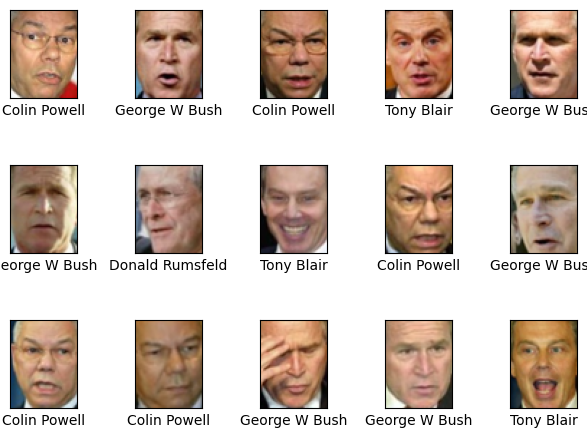

In [3]:
# Check by Plotted Images
# Generate random 15 images
rand_labels = [np.random.randint(0, len(faces.data)) for x in range(0,15)]

fig, ax = plt.subplots(3, 5)
fig.tight_layout()
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[rand_labels[i]], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[rand_labels[i]]])

In [4]:
def preprocess_images(images, size=(64, 64)):
    processed_images = []
    for image in images:
        # Resize image to specified dimensions
        resized_image = cv2.resize(image, size)
        # Apply histogram equalization to each channel
        for i in range(3):  # RGB channels
            resized_image[..., i] = cv2.equalizeHist((resized_image[..., i] * 255).astype(np.uint8))
        # Normalize pixel values to [0, 1]
        resized_image = resized_image / 255.0
        processed_images.append(resized_image)
    return np.array(processed_images)

# Preprocess the images
faces_images_processed = preprocess_images(faces.images, size=(64, 64))

In [5]:
# Function to Extract Histogram Features for Each Channel
def generate_hist(data, bins_num=100):
    hist_data = []
    for image in data:
        hist_red = np.histogram(image[..., 0].ravel(), bins=bins_num)[0]
        hist_green = np.histogram(image[..., 1].ravel(), bins=bins_num)[0]
        hist_blue = np.histogram(image[..., 2].ravel(), bins=bins_num)[0]
        hist_data.append(np.concatenate((hist_red, hist_green, hist_blue)))
    return np.array(hist_data)

In [6]:
# Extract histogram features
hist_features = generate_hist(faces_images_processed, bins_num=100)
print(f'Extracted Histogram Features Shape: {hist_features.shape}')

Extracted Histogram Features Shape: (1140, 300)


In [7]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(hist_features, faces.target,
                                                    test_size=0.3, random_state=42,
                                                    stratify=faces.target)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SVM Model with Grid Search for Hyperparameter Tuning
svm_model = SVC()
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4],  # Relevant for 'poly' kernel
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(svm_model, param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'class_weight': [None, 'balanced'],
                         'degree': [2, 3, 4],
                         'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
                         'kernel': ['linear', 'rbf', 'poly']},
             verbose=2)

In [8]:
# Best Model from Grid Search
best_model = grid_search.best_estimator_

Accuracy on Train: 100.00%
Accuracy on Test: 45.32%
                   precision    recall  f1-score   support

     Colin Powell       0.36      0.06      0.10        71
  Donald Rumsfeld       0.00      0.00      0.00        36
    George W Bush       0.46      0.94      0.62       159
Gerhard Schroeder       0.00      0.00      0.00        33
       Tony Blair       0.33      0.02      0.04        43

         accuracy                           0.45       342
        macro avg       0.23      0.20      0.15       342
     weighted avg       0.33      0.45      0.32       342



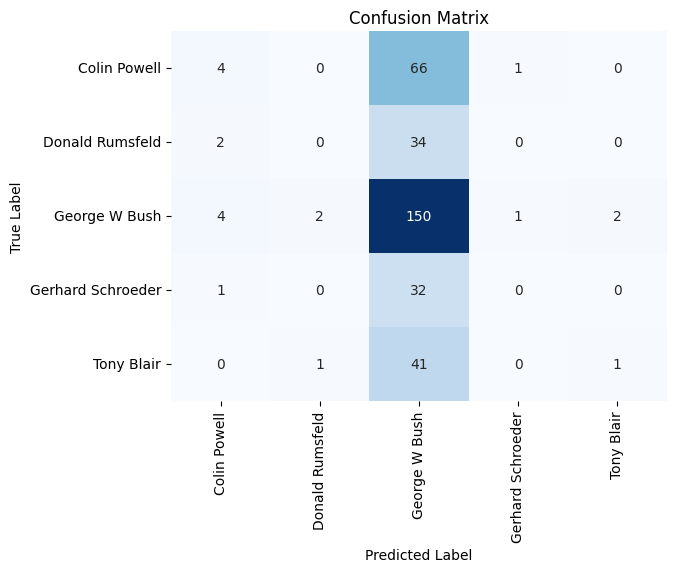

In [9]:
# Evaluation
y_train_predict = best_model.predict(X_train)
y_test_predict = best_model.predict(X_test)

# Print Accuracy
print(f'Accuracy on Train: {accuracy_score(y_train, y_train_predict):.2%}')
print(f'Accuracy on Test: {accuracy_score(y_test, y_test_predict):.2%}')
print(classification_report(y_test, y_test_predict, target_names=faces.target_names))

# Confusion Matrix Visualization
def plot_confusion_matrix(y_true, y_pred, target_names):
    mat = confusion_matrix(y_true, y_pred)
    sns.heatmap(mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=target_names, yticklabels=target_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(y_test, y_test_predict, faces.target_names)

Text(113.92222222222219, 0.5, 'predicted label')

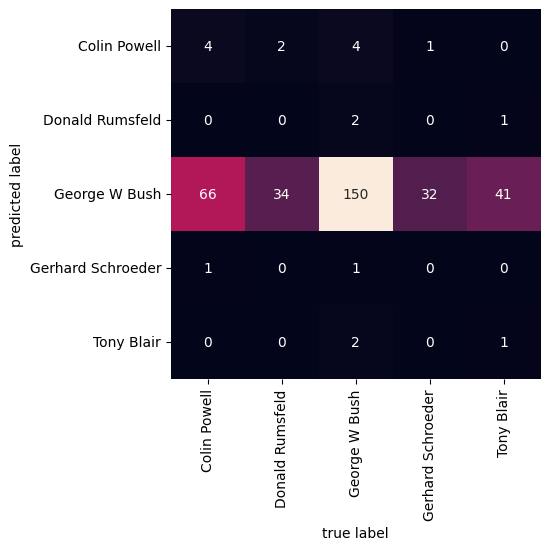

In [10]:
# Eval Confusion Matrix
mat = confusion_matrix(y_test, y_test_predict)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [11]:
# Function to preprocess images
def preprocess_images2(images, size=(64, 64)):
    processed_images = []
    for image in images:
        # Resize image to specified dimensions
        resized_image = cv2.resize(image, size)
        # Normalize pixel values to [0, 1]
        resized_image = resized_image / 255.0
        processed_images.append(resized_image)
    return np.array(processed_images)

# Preprocess the images
faces_images_processed2 = preprocess_images2(faces.images, size=(64, 64))

In [12]:
# Extract HOG features
def generate_hog(data):
    hog_features = []
    for image in data:
        # Convert to grayscale for HOG (but keep RGB for other processing)
        gray_image = (image[..., 0] + image[..., 1] + image[..., 2]) / 3  # Simple average to grayscale
        features = hog(gray_image, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=False)
        hog_features.append(features)
    return np.array(hog_features)

# Extract HOG features from processed images
hog_features = generate_hog(faces_images_processed2)
print(f'Extracted HOG Features Shape: {hog_features.shape}')

Extracted HOG Features Shape: (1140, 1764)


In [13]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(hog_features, faces.target,
                                                    test_size=0.3, random_state=42,
                                                    stratify=faces.target)

# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Hyperparameter tuning using GridSearchCV (optional)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(rf_model, param_grid, cv=5, verbose=2, n_jobs=-1)  # Use cross-validation
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [14]:
# Best Model from Grid Search
best_model = grid_search.best_estimator_

Accuracy on Train: 100.00%
Accuracy on Test: 76.61%

Classification Report (Test Set):
                   precision    recall  f1-score   support

     Colin Powell       0.98      0.86      0.92        71
  Donald Rumsfeld       1.00      0.36      0.53        36
    George W Bush       0.67      1.00      0.80       159
Gerhard Schroeder       1.00      0.30      0.47        33
       Tony Blair       0.95      0.44      0.60        43

         accuracy                           0.77       342
        macro avg       0.92      0.59      0.66       342
     weighted avg       0.84      0.77      0.74       342



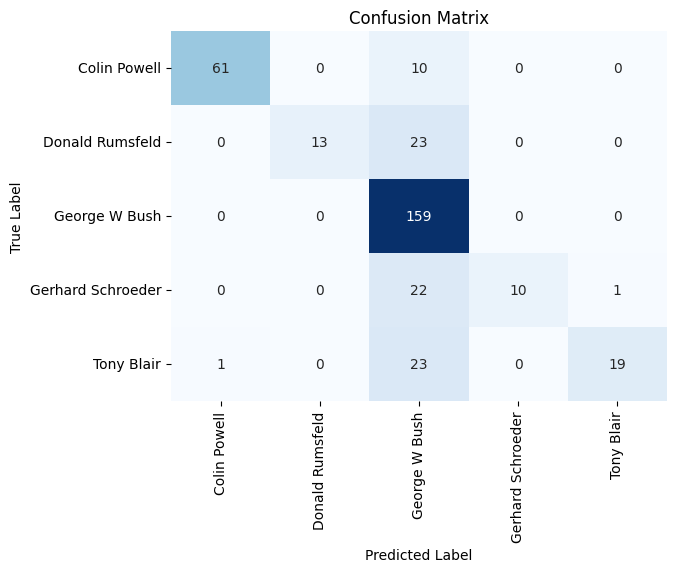

Weighted F1 Score: 0.74


In [15]:
# Evaluation
y_train_predict = best_model.predict(X_train)
y_test_predict = best_model.predict(X_test)

# Print Accuracy
acc_train = accuracy_score(y_train, y_train_predict)
acc_test = accuracy_score(y_test, y_test_predict)

print(f'Accuracy on Train: {acc_train:.2%}')
print(f'Accuracy on Test: {acc_test:.2%}')

# Classification Report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_predict, target_names=faces.target_names))

# Confusion Matrix Visualization
def plot_confusion_matrix(y_true, y_pred, target_names):
    mat = confusion_matrix(y_true, y_pred)
    sns.heatmap(mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=target_names, yticklabels=target_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(y_test, y_test_predict, faces.target_names)

# Additional Metrics
f1 = f1_score(y_test, y_test_predict, average='weighted')
print(f'Weighted F1 Score: {f1:.2f}')